In [45]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier


We load the pima.csv dataframe and print its shape

In [2]:
pima = pd.read_csv('pima.csv')
pima_ncolumns = pima.shape[0]
pima_nrows = pima.shape[1]
print(f'Pima dataset have {pima_nrows} rows and {pima_ncolumns} columns')


Pima dataset have 9 rows and 768 columns


We examine the first instances of the dataset. 

In [3]:
pima.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We print and display the distribution of the Outcome target variable.

In [4]:
pima['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

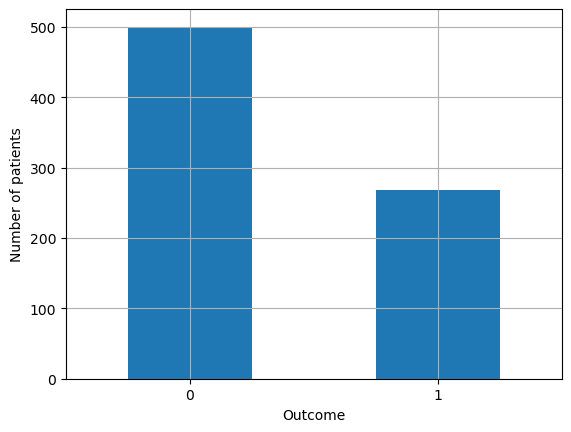

In [5]:
pima['Outcome'].value_counts().plot.bar(rot=0, grid= True)
plt.xlabel('Outcome')
plt.ylabel('Number of patients')
plt.show()

We get a quick description of the dataset and check for missing values along with the type of data.

In [6]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We display the main statistical characteristics of each column in the data in a tabular format to identify columns where the minimum value takes an unreasonable value equal to zero. We will replace those with the median of the coresponding column.

In [7]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We will apply imputation to the features needed according to the tabular data we have displayed. All except 'pregnancies' and 'Outcome' will be imputed.

In [8]:
pima.columns
columns_to_impute = pima[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                         'BMI', 'DiabetesPedigreeFunction', 'Age']]
columns_to_impute_zeros_removed = columns_to_impute.replace(0, np.NaN); columns_to_impute_zeros_removed


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148.0,72.0,35.0,NaN,33.6,0.627,50
1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,183.0,64.0,NaN,NaN,23.3,0.672,32
3,89.0,66.0,23.0,94.0,28.1,0.167,21
4,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...
763,101.0,76.0,48.0,180.0,32.9,0.171,63
764,122.0,70.0,27.0,NaN,36.8,0.340,27
765,121.0,72.0,23.0,112.0,26.2,0.245,30
766,126.0,60.0,NaN,NaN,30.1,0.349,47


In [11]:

#imputer = SimpleImputer(missing_values=0, strategy='median')
imputer = SimpleImputer(strategy='median')


Since all the columns, we are intrested, are numerical attributes we apply the imputer  straightforward to them. First we fit the imputer to the data to get the median values.

In [12]:
imputer.fit(columns_to_impute_zeros_removed)


SimpleImputer(strategy='median')

In [13]:
print(imputer.statistics_)
print(columns_to_impute_zeros_removed.median().values)


[117.      72.      29.     125.      32.3      0.3725  29.    ]
[117.      72.      29.     125.      32.3      0.3725  29.    ]


We apply the imputer to fill 0 values with the median values of their corresponding column.

In [14]:

imputed_columns = imputer.transform(columns_to_impute_zeros_removed)


And we wrap up the NumPy array imputed_columns to the pima_imputed Dataframe to recover the column names and index.

In [15]:

pima_imputed = pd.DataFrame(imputed_columns, columns= columns_to_impute.columns, index= pima.index)


In [16]:
print(pima_imputed.columns)
print(pima.columns)
# print(pima_imputed.describe())
# print(pima.describe())


Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


We add the pima['pregnancies'] column at the beggining and pima['Outcome'] at the end of the Dataframes above to recover the original's pima DataFrame shape with the same Dataframes.

In [17]:

pima_imputed_full1 = pd.concat([pima['Pregnancies'],pima_imputed],axis=1)
pima_imputed_full = pd.concat([pima_imputed_full1,pima['Outcome']], axis= 1)


Finally, we display the updated dataset’s characteristics in a tabular format using the describe() feature.

In [18]:

pima_imputed_full.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [19]:
print(f'The columns affected by this step are: {pima_imputed.columns.to_list()}')


The columns affected by this step are: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


We define the features and the labels as X_p and y_p

In [20]:


X_p = pima_imputed_full.drop('Outcome', axis=1)
y_p = pima_imputed_full['Outcome']


And we perform a stratified split of the dataset, allocating 700 instances to the training set and the remaining samples as the test set, ensuring that the target variable is the Outcome column, while the rest of the columns constitute the feature space for the classification task.

In [21]:

X_p_train, X_p_test, y_p_train, y_p_test = train_test_split( X_p, y_p, test_size= 68, 
                                                   stratify= y_p , random_state=42)


We check the outcome by measuring the instances allocated to train and test sets.

In [22]:

print(X_p_train.shape, X_p_test.shape)
print(y_p_train.shape, y_p_test.shape)


(700, 8) (68, 8)
(700,) (68,)


And we finally compare the proportion of the class labels before the stratified split and after that, on both train and test sets. 

In [23]:

y_p.value_counts()/len(y_p)
y_p_train.value_counts()/len(y_p_train)
y_p_test.value_counts()/len(y_p_test) 


Outcome
0    0.647059
1    0.352941
Name: count, dtype: float64

We confirm that through stratification the proportions kept almost identical on the above sets.

We will train 4 different classification models. 

-We first start with a decision tree classifier.

In [24]:
dtree_clf = DecisionTreeClassifier(random_state= 42)
dtree_clf.fit(X_p_train,y_p_train)


DecisionTreeClassifier(random_state=42)

-We train a Random Forest Classifier.

In [28]:
randforest_clf = RandomForestClassifier(random_state=42)
randforest_clf.fit(X_p_train,y_p_train)

RandomForestClassifier(random_state=42)

-We train a Bagging classifier with an SVM classifier (linear kernel) and 10 estimators.

In [34]:
svc_linear_kernel = Pipeline([
    ('scaler', StandardScaler()),
    ('svc_linear_kernel', SVC(kernel='linear', random_state=42))
])
bag_clf = BaggingClassifier(svc_linear_kernel, n_estimators=10, random_state=42)
bag_clf.fit(X_p_train,y_p_train)


BaggingClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                            ('svc_linear_kernel',
                                             SVC(kernel='linear',
                                                 random_state=42))]),
                  random_state=42)

-We train an AdaBoost classifier with a decision tree classifier, using 100 estimators and a learning rate of 0.25.

In [37]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, learning_rate= 0.25, random_state=42)
ada_clf.fit(X_p_train,y_p_train)

c:\Users\tasos\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(), learning_rate=0.25,
                   n_estimators=100, random_state=42)

We will display, for each model, a classification report presenting the standard classification metrics, recision,
recall, and f1-score and the confusion matrix as they were calculated on the test set.

We first calculate the metrics and comfusion matrix of the DecisionTreeClassifier

In [40]:
y_pred_dtree_clf = dtree_clf.predict(X_p_test)
cl_report_dtree = print(classification_report(y_p_test, y_pred_dtree_clf))
conf_matrix_dtree = print(confusion_matrix(y_p_test, y_pred_dtree_clf))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80        44
           1       0.63      0.50      0.56        24

    accuracy                           0.72        68
   macro avg       0.69      0.67      0.68        68
weighted avg       0.71      0.72      0.71        68

[[37  7]
 [12 12]]


We calculate the metrics and comfusion matrix of the RandomForest classifier


In [41]:
y_pred_randforest_clf = randforest_clf.predict(X_p_test)
cl_report_randomforest = print(classification_report(y_p_test, y_pred_randforest_clf))
conf_matrix_randomforest = print(confusion_matrix(y_p_test, y_pred_randforest_clf))


              precision    recall  f1-score   support

           0       0.86      0.84      0.85        44
           1       0.72      0.75      0.73        24

    accuracy                           0.81        68
   macro avg       0.79      0.80      0.79        68
weighted avg       0.81      0.81      0.81        68

[[37  7]
 [ 6 18]]


We calculate the metrics and comfusion matrix for the Bagging classifier. 

In [42]:
y_pred_bag_clf = bag_clf.predict(X_p_test)
cl_report_bagging = print(classification_report(y_p_test, y_pred_bag_clf))
conf_matrix_randomforest = print(confusion_matrix(y_p_test, y_pred_bag_clf))


              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.62      0.62      0.62        24

    accuracy                           0.74        68
   macro avg       0.71      0.71      0.71        68
weighted avg       0.74      0.74      0.74        68

[[35  9]
 [ 9 15]]


And finally we calculate the metrics and comfusion matrix for the AdaBoost classifier.

In [43]:
y_pred_adaboost = ada_clf.predict(X_p_test)
cl_report_bagging = print(classification_report(y_p_test, y_pred_adaboost))
conf_matrix_ada = print(confusion_matrix(y_p_test, y_pred_adaboost))


              precision    recall  f1-score   support

           0       0.74      0.84      0.79        44
           1       0.61      0.46      0.52        24

    accuracy                           0.71        68
   macro avg       0.68      0.65      0.66        68
weighted avg       0.69      0.71      0.69        68

[[37  7]
 [13 11]]


Comparing the performance of the four models we can observe that the DecisionTreeClassifier shows an accuracy of 0.72, with precision, recall, and F1-score metrics indicating relatively balanced performance for class 0 but a lower recall of 0.50 for class 1. This suggests it correctly identifies class 0 better but struggles with class 1. The RandomForestClassifier improves overall accuracy to 0.81, with a higher recall for class 1 at 0.75, indicating it better captures positive instances compared to the DecisionTreeClassifier, while also maintaining strong metrics for class 0. The BaggingClassifier also performs well with an accuracy of 0.74, showing balanced precision and recall for both classes, though slightly lower than the RandomForestClassifier. Lastly, the AdaBoostClassifier achieves an accuracy of 0.71, with a good performance for class 0 but lower metrics for class 1, especially recall at 0.46, indicating it misses more positive instances.
The F1-score, which is the metric that combines precision and recall, the RandomForest classifier achieves the highest for both Classes. And since this is a medical related dataset, ensuring a balance between sensitivity (recall) and precision is crucial to minimize both false negatives and false positives. 


We qualify RandomForestClassifier as the best-performing base model.

We train the Self training classifier with this model and the parameters criterion and threshold set to ‘threshold’ and 0.99 respectively.

In [46]:
self_clf = SelfTrainingClassifier(randforest_clf, threshold=0.99, criterion='threshold')


We use the train_test_split with suffling to create the labeled and unlabeled instances from the training set.

In [47]:
X_p_train_labeled, X_p_train_unlabeled, y_p_train_labeled, y_p_train_unlabeled = train_test_split(X_p_train, y_p_train,
                                                           test_size= 500, shuffle=True, random_state= 42)
print(X_p_train_labeled.shape)
print(X_p_train_unlabeled.shape)
print(y_p_train_labeled.shape)
print(y_p_train_unlabeled.shape)

(200, 8)
(500, 8)
(200,)
(500,)


In [48]:
y_p_train_unlabeled[:5] #A quick check the values of the class of the y_p_train_unlabeled.


748    1
686    0
408    1
282    0
423    0
Name: Outcome, dtype: int64

We substitute every class value of the y_p_train_unlabeled with -1 to mark it as unlabeled data.

In [49]:

y_p_train_unlabeled = np.full(y_p_train_unlabeled.shape[0], -1)
print(y_p_train_unlabeled[:10])
print(y_p_train_unlabeled.shape)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(500,)


We combine the unlabeled and labeled to use it on the semisupervised model.

In [50]:

X_train_combined = np.vstack((X_p_train_labeled, X_p_train_unlabeled))
y_train_combined = np.hstack((y_p_train_labeled, y_p_train_unlabeled))


We train the self training classifier using the combination of the unlabeled and labeled data.

In [51]:

self_clf.fit(X_train_combined,y_train_combined)


SelfTrainingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                       threshold=0.99)

And we calculate the metrics and comfusion matrix for the self training classifier.

In [52]:

y_pred_combined = self_clf.predict(X_p_test)
cl_report_self = print(classification_report(y_p_test, y_pred_combined))
conf_matrix_self = print(confusion_matrix(y_p_test, y_pred_combined))


              precision    recall  f1-score   support

           0       0.75      0.89      0.81        44
           1       0.69      0.46      0.55        24

    accuracy                           0.74        68
   macro avg       0.72      0.67      0.68        68
weighted avg       0.73      0.74      0.72        68

[[39  5]
 [13 11]]


c:\Users\tasos\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


We train the qualified model RandomForestClassifier with only the labeled data we created with the shuffled train_test_split method.

In [53]:

randforest_clf.fit(X_p_train_labeled, y_p_train_labeled)


RandomForestClassifier(random_state=42)

And we calculate the metrics and comfusion matrix for the random forest classifier.

In [54]:

y_pred_labeled = randforest_clf.predict(X_p_test)
cl_report_labeled = print(classification_report(y_p_test, y_pred_labeled))
conf_matrix_labeled = print(confusion_matrix(y_p_test, y_pred_labeled))


              precision    recall  f1-score   support

           0       0.79      0.86      0.83        44
           1       0.70      0.58      0.64        24

    accuracy                           0.76        68
   macro avg       0.75      0.72      0.73        68
weighted avg       0.76      0.76      0.76        68

[[38  6]
 [10 14]]


Comparing the results between these two models, seems that the randomForestClassifier is overall performing slightly better. 